In [44]:
import copy
import json
import os
import pathlib
import sys
import random
import pickle
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

# shap displays NumbaDeprecationWarning when importing -- supress them
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

import shap
import torch
from torch import Tensor, sigmoid

# logging.basicConfig(level=logging.INFO)

# correct path to repository root
REPOSITORY_ROOT = os.path.join(os.getcwd(), "..", "..", "..")
sys.path.append(REPOSITORY_ROOT)

from nebula import PEDynamicFeatureExtractor
from nebula.models.attention import TransformerEncoderOptionalEmbedding, TransformerEncoderChunks
from nebula.preprocessing import JSONTokenizerNaive

from nebula.misc.plots import set_size

from nebula.misc import fix_random_seed
fix_random_seed(0)


def compute_score(llm, x, verbose=True):
    logit = llm(x)
    prob = sigmoid(logit)
    if verbose:
        print(f"\n[!!!] Probability of being malicious: {prob.item():.3f} | Logit: {logit.item():.3f}")
    return prob


def load_tokenizer():
    with open(os.path.join(REPOSITORY_ROOT, "nebula", "objects",
                           "speakeasy_whitespace_50000_vocab.json")) as f:
        vocab = json.load(f)

    tokenizer = JSONTokenizerNaive(
        vocab_size=len(vocab),
        seq_len=512,
        vocab=vocab
    )
    return tokenizer


def tokenize_sample(report_path, encode=True):
    extractor = PEDynamicFeatureExtractor()
    filtered_report = extractor.filter_and_normalize_report(report_path)
    tokenizer = load_tokenizer()
    tokenized_report = tokenizer.tokenize(filtered_report)
    if encode:
        encoded_report = tokenizer.encode(tokenized_report, pad=True, tokenize=False)
        x = Tensor(encoded_report).long()
        return x
    else:
        return tokenized_report


def embed(llm_model, report, device="cpu"):
    src = tokenize_sample(report)
    s = llm_model.split(src)
    s = s.to(device)
    e = llm_model.embed(s)
    return e


def plot_shap_values(shap_values: np.ndarray, name: str):
    shap_values = shap_values.mean(axis=2)
    pos_idx = shap_values[0] >= 0
    neg_index = shap_values[0] < 0
    pos_shap = copy.deepcopy(shap_values)[0]
    pos_shap[neg_index] = 0
    neg_shap = copy.deepcopy(shap_values)[0]
    neg_shap[pos_idx] = 0
    x = range(512)
    plt.bar(x, pos_shap)
    plt.bar(x, neg_shap)
    plt.title(name)
    plt.show()


def load_model(skip_embedding=False):
    # state dict
    multiclass_model_folder = os.path.join(REPOSITORY_ROOT, r"evaluation\paper_sota\out_speakeasy_multiclass\cv_nebulawht_limNone_r1763_t5\training_files")
    pretrained_model = [os.path.join(multiclass_model_folder, x) for x in os.listdir(multiclass_model_folder) if x.endswith(".torch")][0]
    state_dict = torch.load(pretrained_model, map_location='cpu')

    # model class
    multiclass_data_folder = os.path.join(REPOSITORY_ROOT, r"evaluation\paper_sota\out_speakeasy_multiclass\nebulawht_speakeasy_vocab_50000_seqlen_512")
    y_train = np.load(os.path.join(multiclass_data_folder, "y_train_full.npy"))
    n_unique_y = len(np.unique(y_train))
    
    with open(os.path.join(multiclass_data_folder, f"tokenizer_50000_vocab.json")) as f:
        nebula_vocab = json.load(f)
    model_config = {
        "vocab_size": len(nebula_vocab),
        "maxlen": 512,
        "chunk_size": 64,  # input splitting to chunks
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": n_unique_y,
        "hiddenNeurons": [64],  # classifier ffnn dims
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True,
        "skip_embedding": skip_embedding
    }
    llm = TransformerEncoderOptionalEmbedding(**model_config)
    llm.load_state_dict(state_dict)
    llm.eval()
    return llm


In [51]:
def generalize_shap_values(reports, model, embed_baseline, threshold=0.5, verbose=True):
    explanations = {}
    if isinstance(reports, pathlib.Path):
        generator = reports.glob("*.json")
    if isinstance(reports, list):
        generator = [x for x in reports if x.endswith("json")]
    length = len(generator)
    for i, report in enumerate(generator):
        print(f"[*] Processing: {i}/{length}", end="\r")
        try:
            name = report.name
        except AttributeError:
            name = report
        if verbose:
            print(name)
        x_embed = embed(model, str(report))
        # prob = compute_score(model, x_embed, verbose=verbose)
        explainer = shap.GradientExplainer(model, data=embed_baseline)
        explanations = explainer.shap_values(x_embed, nsamples=50)
        token_idxs = tokenize_sample(str(report), encode=True)
        explanations[name] = (explanations, token_idxs)
    print() # newline to preserve processing output
    return explanations


def aggregate_values(data, vocab, aggregate="mean", limit=1000, name=""):
    assert aggregate in ["mean", "sum"]
    aggregate_file = os.path.join("multiclass", f"explanations_{name}_agg_{aggregate}_lim_{limit}.json")
    
    if os.path.exists(aggregate_file):
        print(f"[!] Loading aggregated explanations from '{aggregate_file}'...")
        with open(aggregate_file, "r") as f:
            output_dict = json.load(f)
        return output_dict
    
    # Initialize an output dictionary with vocab keys and values set to zero
    output_dict = {k: [] for k in vocab.keys()}

    # Iterate through each name in data
    for values, token_idxs in tqdm(data.values()):
        # Average the shap values across the embedding dimension
        values = values.mean(axis=2).squeeze().tolist()
        token_idxs = token_idxs.squeeze().tolist()
        for v, idx in zip(values, token_idxs):
            # For each token index, find the corresponding token in vocab
            token = [k for k, i in vocab.items() if i == idx][0]
            # Add the value to the output_dict for that token
            output_dict[token].append(v)
    
    if aggregate == "mean":
        for k, v in output_dict.items():
            output_dict[k] = np.mean(v)
    elif aggregate == "sum":
        for k, v in output_dict.items():
            output_dict[k] = np.sum(v)

    # write output dict as json
    with open(aggregate_file, "w") as f:
        json.dump(output_dict, f, indent=4)
    
    return output_dict


def gather_explanations(folder, model, x_embed_baseline, limit=1000):
    # NOTE: limit=1000 files takes ~35 mins
    ware_type = folder.split("\\")[-1].replace("report_", "")
    print(f"[!] Working on '{ware_type}'...")

    files = [os.path.join(folder, x) for x in os.listdir(folder)]
    # randomly subsample 'limit' files
    files_limited = random.sample(files, min(limit, len(files)))

    explanations_file = os.path.join("multiclass", f"explanations_{ware_type}_lim_{limit}_multiclass.pickle")

    if os.path.exists(explanations_file):
        print(f"[!] Loading explanations from '{explanations_file}'...")
        with open(explanations_file, "rb") as f:
            explanations = pickle.load(f)
    else:
        explanations = generalize_shap_values(
            files_limited,
            model,
            x_embed_baseline,
            verbose=False,
            clean=None)
        # dump as pickle
        with open(explanations_file, "wb") as f:
            pickle.dump(explanations_t, f)
        
    return explanations

### Loading Pretrained Objects

In [52]:
model = load_model()
model_no_embed = load_model(skip_embedding=True)
tokenizer = load_tokenizer()

malware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "malware"))
goodware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "goodware"))

baseline_report = os.path.join(REPOSITORY_ROOT, r"emulation", "report_baseline.json")

x_baseline = tokenize_sample(baseline_report)
x_embed_baseline = embed(model, baseline_report)

In [53]:
LIMIT = 50

testset_folder = os.path.join(REPOSITORY_ROOT, r"data\windows_emulation_testset")
for folder in os.listdir(testset_folder):
    if "syswow64" in folder:
        continue
    
    tp, fn = gather_explanations(os.path.join(testset_folder, folder), model_no_embed, x_embed_baseline, limit=LIMIT)
    
    tp_file = f"tn_{folder.replace('report_', '')}" if (folder.endswith("clean")) else f"tp_{folder.replace('report_', '')}"
    aggregate_values(tp, tokenizer.vocab, aggregate="mean", limit=LIMIT, name=tp_file) # ~10 min for 700 explanations
    
    fn_file = f"fp_{folder.replace('report_', '')}" if (folder.endswith("clean")) else f"fn_{folder.replace('report_', '')}"
    aggregate_values(fn, tokenizer.vocab, aggregate="mean", limit=LIMIT, name=fn_file)
    
    print() # to add gap between runs

[!] Working on 'backdoor'...


TypeError: list indices must be integers or slices, not str


[!] explanations_tn_clean_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


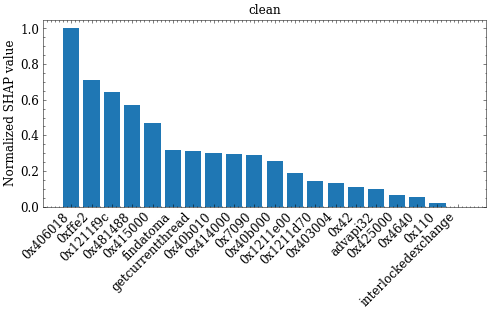


[!] explanations_tn_windows_syswow64_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


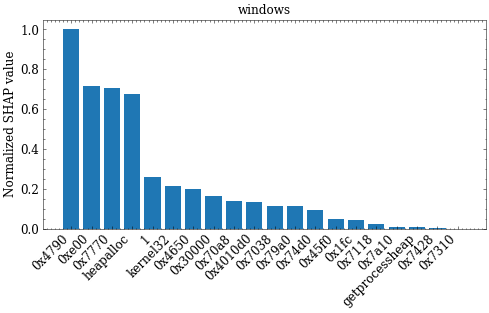


[!] explanations_tp_backdoor_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


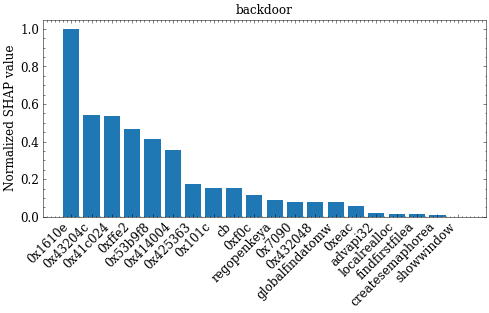


[!] explanations_tp_coinminer_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


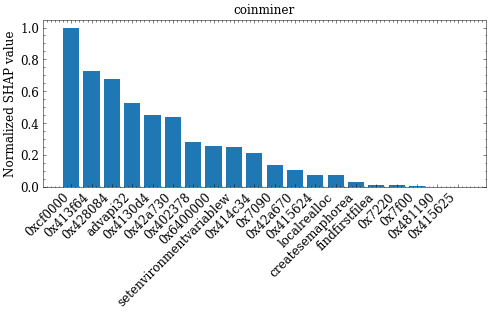


[!] explanations_tp_dropper_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


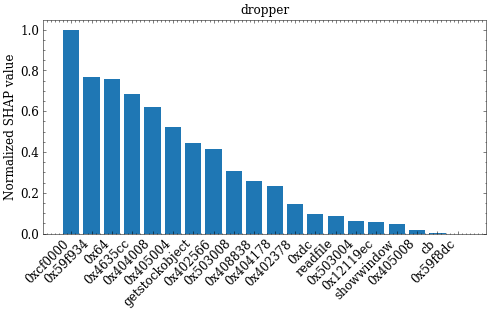


[!] explanations_tp_keylogger_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


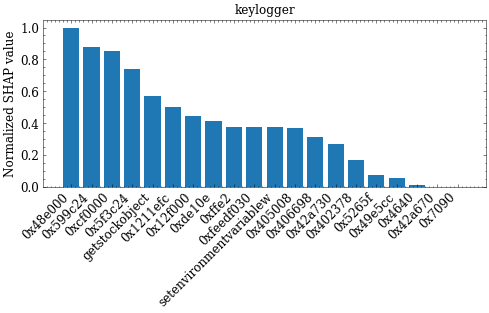


[!] explanations_tp_ransomware_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


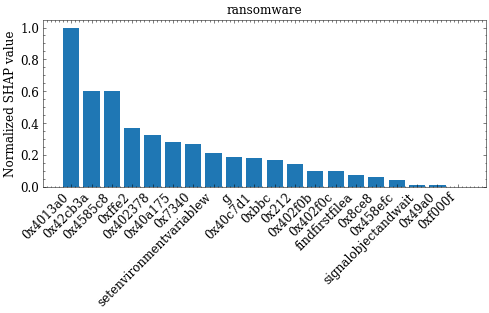


[!] explanations_tp_rat_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


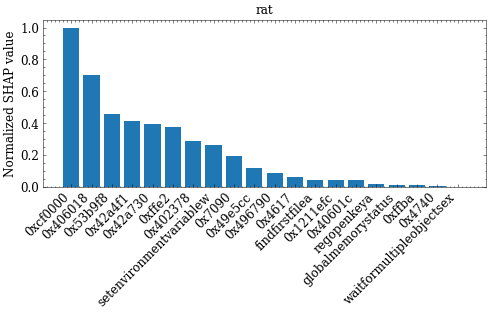


[!] explanations_tp_trojan_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


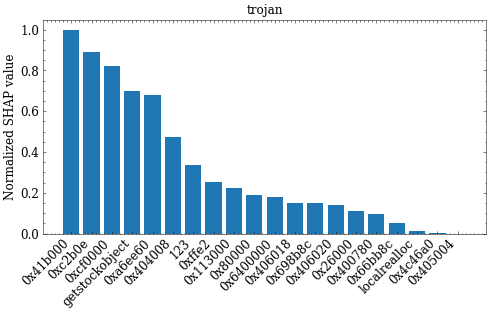

In [12]:
TOP = 20

def plot_top_features(agg_shap_tokens_tp, skip=0, color="tab:blue"):
    for k, v in agg_shap_tokens_tp.items():
        if np.isnan(v):
            agg_shap_tokens_tp[k] = 0
    top_tp_features = sorted(agg_shap_tokens_tp.items(), key=lambda x: x[1], reverse=True)[:TOP]

    x = [x[0] for x in top_tp_features][skip:]
    y = np.array([x[1] for x in top_tp_features][skip:])
    # normalize y to be within [0, 1]
    y = (y - y.min()) / (y.max() - y.min())

    fig, ax = plt.subplots(figsize=set_size())
    ax.bar(x, y, color=color)
    ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
    ax.set_yticklabels([f"{x:.1f}" for x in ax.get_yticks()], fontsize=12)
    _ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
    plt.tight_layout()
    return ax


for agg_shap_tokens_tp_file in [x for x in os.listdir(".") if x.startswith("explanations_t") and x.endswith(".json")]:
    print(f"\n[!] {agg_shap_tokens_tp_file}")
    with open(agg_shap_tokens_tp_file, "r") as f:
        agg_shap_tokens_tp = json.load(f)
    
    ax = plot_top_features(agg_shap_tokens_tp)
    title = agg_shap_tokens_tp_file.replace("explanations_t", "").split("_")[1]
    ax.set_title(title)
    plt.show()

### Aggregating tokens over all the malware types

In [19]:
agg_malware_tp = {}

for agg_shap_tokens_tp_file in [x for x in os.listdir(".") if x.startswith("explanations_tp") and x.endswith(".json")]:
    with open(agg_shap_tokens_tp_file, "r") as f:
        agg_shap_tokens_tp = json.load(f)
    
    for k, v in agg_shap_tokens_tp.items():
        if k not in agg_malware_tp:
            agg_malware_tp[k] = []
        agg_malware_tp[k].append(v)
    
agg_malware_tp = {k: np.mean(v) for k, v in agg_malware_tp.items()}
# fill nan in agg_malware_tp
for k, v in agg_malware_tp.items():
    if np.isnan(v):
        agg_malware_tp[k] = 0
agg_malware_tp_sorted = {k: v for k, v in sorted(agg_malware_tp.items(), key=lambda x: x[1], reverse=True)}

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


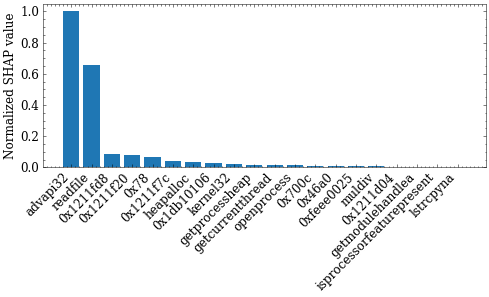

In [20]:
ax = plot_top_features(agg_malware_tp, skip=0)

### Same for clean software

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


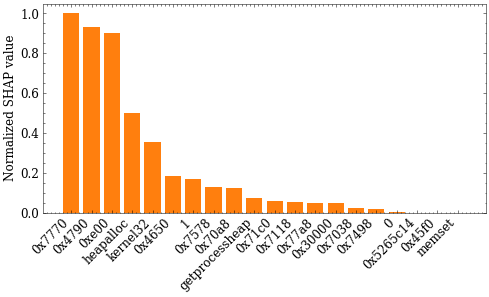

In [21]:
agg_clean_tn = {}

for agg_shap_tokens_tn_file in [x for x in os.listdir(".") if x.startswith("explanations_tn") and x.endswith(".json")]:
    with open(agg_shap_tokens_tn_file, "r") as f:
        agg_shap_tokens_tn = json.load(f)
    
    for k, v in agg_shap_tokens_tn.items():
        if k not in agg_clean_tn:
            agg_clean_tn[k] = []
        agg_clean_tn[k].append(v)

agg_clean_tn = {k: np.mean(v) for k, v in agg_clean_tn.items()}
# fill nan in agg_clean_tn
for k, v in agg_clean_tn.items():
    if np.isnan(v):
        agg_clean_tn[k] = 0
agg_clean_tn_sorted = {k: v for k, v in sorted(agg_clean_tn.items(), key=lambda x: x[1], reverse=True)}

ax = plot_top_features(agg_clean_tn_sorted, skip=0, color="tab:orange")

### Diverging bar plot

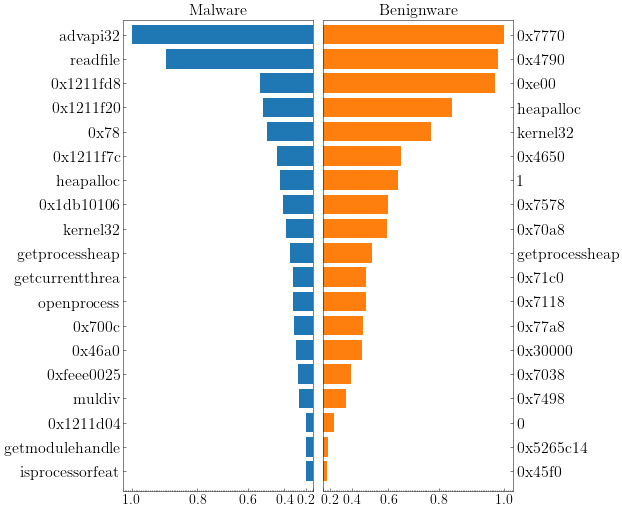

In [27]:
plt.style.use(['science'])
# plt.style.use(['science', 'no-latex'])

def power_transform(x, alpha=0.5):
    return np.power(x, alpha)

def inverse_power_transform(y, alpha=0.5):
    return np.power(y, 1/alpha)

# Extract and normalize positive class data
FEATURE_LIM = 15 # chars
SKIP = 0
TOP = 20
x_pos = [k[:FEATURE_LIM] for k in list(agg_malware_tp_sorted.keys())][SKIP:][:TOP]
y_pos = np.array([v for v in list(agg_malware_tp_sorted.values())][SKIP:])[:TOP]
y_pos = (y_pos - y_pos.min()) / (y_pos.max() - y_pos.min()) # normalize
y_pos = power_transform(y_pos)

# Extract and normalize negative class data
x_neg = [k[:FEATURE_LIM] for k in agg_clean_tn_sorted.keys()][SKIP:][:TOP]
y_neg = np.array([v for v in agg_clean_tn_sorted.values()][SKIP:])[:TOP]
y_neg = (y_neg - y_neg.min()) / (y_neg.max() - y_neg.min())
y_neg = power_transform(y_neg)

# Create a figure and axis
sizes = set_size()
fig, axs = plt.subplots(1, 2, figsize=(sizes[0], sizes[1]*2))  # Adjust the size as needed

ax = axs[0]
# Plot positive values
ax.barh(np.arange(len(x_pos)), y_pos, color='tab:blue', label='Positive', align='edge')

ax.set_yticks(np.arange(len(x_pos)) + 0.4)
ax.set_yticklabels(x_pos, fontsize=16)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_title("Malware", fontsize=16)

ax2 = axs[1]
# # Plot negative values on the second x-axis
ax2.barh(np.arange(len(x_neg)), y_neg, color='tab:orange', label='Negative', align='edge')
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_right()

ax2.set_yticks(np.arange(len(x_neg)) + 0.4)
ax2.set_yticklabels(x_neg, fontsize=16)
ax2.set_title("Benignware", fontsize=16)

# remove minor yticks
from matplotlib.ticker import NullLocator
ax.yaxis.set_minor_locator(NullLocator())
ax2.yaxis.set_minor_locator(NullLocator())

# # Adjust layout
fig.subplots_adjust(wspace=0.05)

# discarded
# ax.grid(linewidth=0.3)
# ax2.grid(linewidth=0.3)
# plt.tight_layout()

# Get the locations in the transformed scale
original_ticks = ax.get_xticks()
transformed_tick_locations = inverse_power_transform(original_ticks, alpha=0.5)

# Apply to the plot axis
new_ticks = np.round(original_ticks, 2)
new_ticks = [str(x) if x != 0.0 else '' for x in new_ticks]

ax.set_xticks(transformed_tick_locations)
ax.set_xticklabels(new_ticks, fontsize=14)
new_ticks = [str(x) if x != '' else '' for x in new_ticks]
ax2.set_xticks(transformed_tick_locations)
ax2.set_xticklabels(new_ticks, fontsize=14)

ax.set_xlim([0,1.05])
ax.invert_xaxis()

ax.set_ylim([-0.2,19.2])
ax.invert_yaxis()

ax2.set_ylim([-0.2,19.2])
ax2.invert_yaxis()

_ = ax2.set_xlim([0, 1.05])

# save as pdf in img
plt.savefig(os.path.join(REPOSITORY_ROOT, "img", "malware_cleanware_shap_values.pdf"), bbox_inches='tight', dpi=300)